In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import utils, nlp_utils
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# LDA - Wall Street Market

## Data Processing

In [ ]:
def clean_parse_text(text):
    '''
   
    Args:
        
        
    Return:
        
    '''
    text = BeautifulSoup(text, 'html.parser').get_text().lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r"[^\w\s]", '', text)
    cleaned_text = re.sub(r'\w*\d\w*', '', text)
    return cleaned_text

def tokenize_lemmatize(text):
    '''
    Removes HTML tags and stopwords.
    Converts words to its base using lemmatization.
    
    
    Args:
        comment (str) : Content of the author's post in Wall Street Market.
        
    Return:
        lem_tokens (arr) : The cleaned, tokenized and lemmetized version of comment.
        
    '''
    
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    
    wordnet_lemma = nltk.WordNetLemmatizer()
    lem_tokens = [wordnet_lemma.lemmatize(t) for t in tokens]
    
    return lem_tokens

In [2]:
# wallstreet = pd.read_csv('data/wallstreet.csv')
# wall_nlp = wallstreet[['subforum', 'contentWithHTMLTag']].copy()
# wall_nlp['cleaned_content'] = wall_nlp['contentWithHTMLTag'].apply(lambda x: nlp_utils.clean_parse_text(x))
# wall_nlp['lemmatized_tokens'] = wall_nlp['cleaned_content'].apply(lambda x: nlp_utils.tokenize_lemmatize(x))
# wall_nlp.to_csv('data/wall_nlp.csv', index=False)

In [ ]:
wall_nlp = pd.read_csv('data/wall_nlp.csv')

--- 
# Bag of Words

In [ ]:
def convert_to_bow_and_fit_lda_model(docs_raw, max_feats, freq_thresh, n_topics, learning_method, max_iter, random_state=3):
    '''
    Convert text into a vector representation, i.e. Bag of Words.
    
    Args:
        docs_raw (arr) : An array comprised of numerous texts.
        max_feats (int) : Number of words to limit the bag-of-words.
        freq-thresh (float) : Words that have a document frequency greater than the selected amount will be ignored.
    Return:
        text_transformed (arr) : Vectorized texted.
    
    '''
    
    vectorizer = CountVectorizer(max_features=max_feats, max_df=freq_thresh)
    docs_vectorized = vectorizer.fit_transform(docs_raw)

    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=random_state, n_jobs=-1)
    lda_output = lda_model.fit_transform(docs_vectorized)
    
    return lda_output, lda_model, docs_vectorized, vectorizer

In [3]:
# wall_nlp.head()

In [3]:
# Must be even for visualizations.
n_topics = 25
max_doc_freq = 0.3

cleaned_content = wall_nlp['lemmatized_tokens']
lda_output_bow, lda_model_bow, docs_vectorized_bow, vect_bow = nlp_utils.convert_to_bow_and_fit_lda_model(cleaned_content, 10000, max_doc_freq, n_topics, 'batch', 25, 3)

sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

In [4]:
nlp_utils.print_topics(lda_model_bow, vect_bow, 10)


Topic #0:
drop bank account market wrote need pm uk selling profile

Topic #1:
name address number card com country cvv url vbv offer

Topic #2:
order utopia offer refund reship kush gramo http btc europe

Topic #3:
like would people know forum think post wrote vendor make

Topic #4:
offer http profile new quality passport need license high get

Topic #5:
http id php viewtopic get rule help wsm phished dreadditevelidot

Topic #6:
vendor good order review product note quality one time would

Topic #7:
offer gram quality price best market high mdma http hash

Topic #8:
http profile wallstyizjhkrvmj market wsm store bump infodesk infodesksorcvsgq leaguemodegrams

Topic #9:
account transfer paypal card btc money bank fund cash need

Topic #10:
click file key page tail new go password see button

Topic #11:
profile http wallstyizjhkrvmj shop offers picsou wsm link offer kallashnikov

Topic #12:
deal free way become world cocaine absolutely gold market mdma

Topic #13:
method get wrote guid

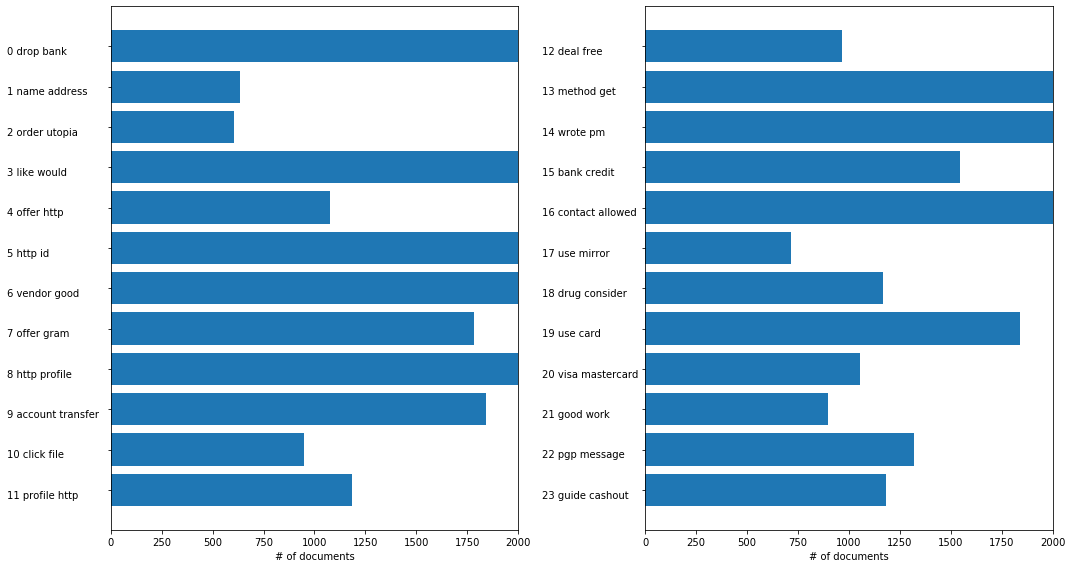

In [5]:
# Evaluate each topics (components) overall weight.
# Topics are named by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 2000
plot_pad = 100
fig_size = (15,8)
num_cols = 2

fig, ax = plt.subplots(1, 2, figsize=fig_size)

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [6]:
# Topic order is based on topic popularity.
# The distance b/t circles reprsents an approximation topic similarity. It's approximation b/c only a 2D map.
# When lambda = 0, the bar chart solely show topic-specific terms (jargon).
doc_term_matrix = np.matrix(lda_model_bow.components_)
pyLDAvis.sklearn.prepare(lda_model_bow, doc_term_matrix, vect_bow)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.182301 -0.112390       1        1  9.660976
3     -0.194020 -0.115739       2        1  9.282101
5      0.284512 -0.173503       3        1  8.021562
6     -0.141594 -0.023604       4        1  7.613495
19    -0.186231  0.044736       5        1  7.070523
24    -0.125549 -0.115973       6        1  6.160972
20    -0.148528  0.094463       7        1  5.433932
7      0.028602  0.122802       8        1  4.564700
15    -0.071682  0.148790       9        1  4.282438
23     0.044001  0.123923      10        1  4.215613
16     0.005111 -0.063910      11        1  4.132920
9     -0.097628  0.078578      12        1  3.840150
10    -0.108080  0.012634      13        1  2.701875
22    -0.085053  0.009170      14        1  2.693283
2      0.051478  0.157136      15        1  2.654746
0     -0.026386 -0.058402      16        1  2.628485
8      0.382899 -0.080381      17        1  2.439437
4      0.145415  0.117211      18        1  2.111674
11     0.281354  0.035339      19        1  2.060024
14     0.019636 -0.206592      20        1  1.956935
18    -0.101177 -0.130509      21        1  1.619938
21     0.073907 -0.106478      22        1  1.277453
12     0.049670 -0.092774      23        1  1.219238
17     0.022325  0.112236      24        1  1.188025
1      0.079319  0.223237      25        1  1.169504, topic_info=                  Term          Freq         Total Category  logprob  loglift
4209              http  40286.000000  40286.000000  Default  30.0000  30.0000
6502               php  15832.000000  15832.000000  Default  29.0000  29.0000
9487         viewtopic  15735.000000  15735.000000  Default  28.0000  28.0000
4272                id  17567.000000  17567.000000  Default  27.0000  27.0000
6063             offer  15840.000000  15840.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
9419            vendor    339.647897  13557.200879  Topic25  -4.1153   0.7618
6063             offer    339.975471  15840.290549  Topic25  -4.1143   0.6072
4440       information    182.315883   1921.108715  Topic25  -4.7374   2.0937
6362          password    156.242021    937.344516  Topic25  -4.8918   2.6569
9581  wallstyizjhkrvmj    177.802269  12566.637340  Topic25  -4.7625   0.1905

[1815 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         3  0.836195        ____
2        11  0.083619        ____
3         3  0.818374     _______
3         7  0.090930     _______
4         2  0.954813  __________
...     ...       ...         ...
9992     21  0.949853    автоматы
9993     21  0.911483   бесплатно
9995     21  0.949853     игровые
9996     21  0.911483      казино
9999     21  0.935091      онлайн

[6170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 4, 6, 7, 20, 25, 21, 8, 16, 24, 17, 10, 11, 23, 3, 1, 9, 5, 12, 15, 19, 22, 13, 18, 2])

### Model Performance

In [7]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', lda_model_bow.score(docs_vectorized_bow))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda_model_bow.perplexity(docs_vectorized_bow))

# Model parameters
print(lda_model_bow.get_params())

Log Likelihood:  -11963994.886210017
Perplexity:  864.2445698802659
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


```
Log Likelihood:  -11984582.0120155
Perplexity:  874.359226243995
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
```

---
# TF-IDF

In [8]:
# Must be even for visualizations.
n_topics = 
max_doc_freq = 0.3

tokens = wall_nlp['lemmatized_tokens']
lda_output_tfidf, lda_model_tfidf, docs_vectorized_tfidf, vect_tfidf = nlp_utils.calculate_tfidf_and_fit_lda_model(tokens, 10000, max_doc_freq, n_topics, 'batch', 25, 3)

sorted_components = np.argsort(lda_model_tfidf.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_tfidf.get_feature_names())

In [11]:
nlp_utils.print_topics(lda_model_tfidf, vect_tfidf, 10)


Topic #0:
drop bank pm account need fullz market paypal wrote looking

Topic #1:
powerhouse note deal become existence unfree rebellion act absolutely world

Topic #2:
utopia vouch stepsauce offer go kush order weed reship gramo

Topic #3:
interested adderall thank stock profile pill suboxone legit look bar

Topic #4:
offer http profile met dxm brand lotto deusxmacinacharity method wall

Topic #5:
guide cashout bank record ssn pack extra link offer sale

Topic #6:
ai wallstyizjhkrvmj profile ok http storehttp pinkypink ref signup online

Topic #7:
pgp begin signature message end signed hash sample mirror onionshop

Topic #8:
http viewtopic php id rule dreadditevelidot phished signup ref help

Topic #9:
card account italian cc profile bank transfer sim selling service

Topic #10:
key pgp thanks message public click hello private decrypt lol

Topic #11:
picsou http shop offers profile wallstyizjhkrvmj paypal samaritan link ukfruits

Topic #12:
profile mdma ketamine cocaine ecstasy http 

In [12]:
doc_term_matrix = np.matrix(lda_model_tfidf.components_)
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_term_matrix, vect_tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.152285  0.014366       1        1  30.834315
13     0.173385 -0.015493       2        1  10.441667
8     -0.040515 -0.276758       3        1   9.006152
17     0.168618 -0.010164       4        1   6.605892
0      0.173608 -0.078238       5        1   6.280331
7     -0.035115  0.121103       6        1   6.170440
9      0.110833 -0.041599       7        1   3.247116
16     0.116940 -0.097886       8        1   3.167162
5      0.022877 -0.047073       9        1   3.146965
15    -0.306930 -0.128381      10        1   2.860420
18     0.096925  0.053777      11        1   2.732460
1      0.027539  0.070016      12        1   2.441946
2     -0.046198  0.196525      13        1   2.034246
4     -0.061145  0.035910      14        1   1.860955
10     0.035635  0.032989      15        1   1.840656
3     -0.010661  0.076169      16        1   1.819015
11    -0.166009 -0.076648      17        1   1.567120
12    -0.197361  0.113442      18        1   1.505817
6     -0.175639 -0.016583      19        1   1.412402
14    -0.039071  0.074527      20        1   1.024923, topic_info=                  Term         Freq        Total Category  logprob  loglift
4209              http  2925.000000  2925.000000  Default  30.0000  30.0000
9487         viewtopic  1583.000000  1583.000000  Default  29.0000  29.0000
6502               php  1584.000000  1584.000000  Default  28.0000  28.0000
4272                id  1622.000000  1622.000000  Default  27.0000  27.0000
9581  wallstyizjhkrvmj  1086.000000  1086.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
9851             wrote    11.297250  1007.492734  Topic20  -5.2243   0.0899
8987                tr     9.218773    38.686418  Topic20  -5.4276   3.1463
2647             dream     9.571937   123.772314  Topic20  -5.3901   2.0209
2246        definitely     9.134050    80.497810  Topic20  -5.4369   2.4043
132              added     9.083404    89.356692  Topic20  -5.4424   2.2944

[1316 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
5        13  0.916538  ________________
17        1  0.406100                ab
17        2  0.252062                ab
17        4  0.042010                ab
17        5  0.070017                ab
...     ...       ...               ...
9950     14  0.975386       yourmomsbox
9951     14  0.938554  yourmomsboxworld
9969      5  0.963085             zelle
9978      2  0.840188             zloty
9982     20  0.840717                zu

[4648 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 14, 9, 18, 1, 8, 10, 17, 6, 16, 19, 2, 3, 5, 11, 4, 12, 13, 7, 15])

In [13]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', round(lda_model_tfidf.score(docs_vectorized_tfidf), 2))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', round(lda_model_tfidf.perplexity(docs_vectorized_tfidf), 2))

# Model parameters
print(lda_model_tfidf.get_params())

Log Likelihood:  -1678947.6
Perplexity:  5552.27
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
